## 1. Introduction to Reflexion

### 1.1 Initial Response

In [1]:
import json
import os

with open('vars.json') as f:
    data = json.load(f)

openai_api_key = data["open_ai_api_key"]
langchain_api_key = data["langchain_api_key"]
# tavily_api_key = data["tavily_api_key"]
groq_api_key = data["groq_api_key"]

# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN_API_KEY'] = langchain_api_key

REFLEXION_LOOP_COUNT = 3

In [2]:
# Setting up DB connection 
from langchain_community.utilities import SQLDatabase

# Docker command to run pgvector/postgres container
# docker run --name pgvector-container -e POSTGRES_USER=langchain -e POSTGRES_PASSWORD=langchain -e POSTGRES_DB=langchain -p 6024:5432 -d pgvector/pgvector:pg16
db_config = {
    'dbname': 'postgres',
    'user': 'langchain',
    'password': 'langchain',
    'host': 'localhost',
    'port': '6024'
}

connection_string = f"postgresql+psycopg://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"

db = SQLDatabase.from_uri(connection_string)
print(db.table_info)


CREATE TABLE customer (
	customer_id SERIAL NOT NULL, 
	name VARCHAR(100) NOT NULL, 
	CONSTRAINT customer_pkey PRIMARY KEY (customer_id)
)

/*
3 rows from customer table:
customer_id	name
1	John Doe
2	Jane Smith
3	Alice Johnson
*/


CREATE TABLE feedback (
	feedback_id SERIAL NOT NULL, 
	order_id INTEGER NOT NULL, 
	feedback_text TEXT, 
	CONSTRAINT feedback_pkey PRIMARY KEY (feedback_id), 
	CONSTRAINT feedback_order_id_fkey FOREIGN KEY(order_id) REFERENCES orders (order_id)
)

/*
3 rows from feedback table:
feedback_id	order_id	feedback_text
4	4	Pizza was average.
5	5	Pizza was average.
6	6	Pizza was average.
*/


CREATE TABLE orders (
	order_id SERIAL NOT NULL, 
	customer_id INTEGER NOT NULL, 
	preparation_time INTEGER NOT NULL, 
	order_date TIMESTAMP WITHOUT TIME ZONE DEFAULT CURRENT_TIMESTAMP, 
	CONSTRAINT orders_pkey PRIMARY KEY (order_id), 
	CONSTRAINT orders_customer_id_fkey FOREIGN KEY(customer_id) REFERENCES customer (customer_id)
)

/*
3 rows from orders table:
order_id	custo

In [3]:
from langchain_agents._models import get_llm

# llama3_model = 'llama-3.1-70b-versatile'
llama3_model = 'llama3-70b-8192'

llm_llama3 = get_llm(llm_type='llama3', llm_model=llama3_model, api_key=groq_api_key)

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

from langchain_agents._schemas import AgentState


# from langchain_agents._tools import create_df_from_sql

class Reflexion(BaseModel):
    """Reflection on the generated SQL query."""
    good: str = Field(description="Critique of what is good in the newly generated Postgres SQL query.",
                      default='')
    missing: str = Field(description="Critique of what is missing in the newly generated Postgres SQL query.",
                         default='')
    improvements: str = Field(description="Suggestions for improvements for the newly generated Postgres SQL query.",
                              default='')


class AnswerQuestion(BaseModel):
    """Generate a SQL query to retrieve the data to answer the question. Provide a reflection on the generated query."""

    select_query: str = Field(...,
                              description="A PostgreSQL SELECT statement to retrieve the data inorder to answer the question.")
    df_columns: List[str] = Field(
        ..., description="Ordered names to give the DataFrame columns."
    )
    df_name: str = Field(
        ..., description="The name to give the DataFrame variable in downstream code."
    )
    reflexion: Reflexion = Field(description="Your reflection on the generated select query.",
                                 default=Reflexion())


initial_retrieve_from_db_prompt_string = f"""
You are an expert at PostgreSQL. You have access to a PostgreSQL database 
with the following tables

{db.table_info}

Given a user question related to the data in the database, 
1. Generate an SQL query to retrieve the data that has to be used to answer the question.
2. Critique the generated SQL query. Does it answers the question? What is good about it? What is missing? What can be improved?
3. Provide your answer using the {AnswerQuestion.__name__} tool. """

initial_retrieve_from_db_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", initial_retrieve_from_db_prompt_string),
        ("placeholder", "{messages}"),
    ]
)


def initial_retrieve_from_db_model_llama3(state: AgentState) -> dict:
    """Call model with tools passed in."""
    messages = []

    print("-----------------initial_retrieve_from_db-----------------")
    chain = initial_retrieve_from_db_prompt | llm_llama3.bind_tools([AnswerQuestion])

    retrieve_response = chain.invoke({
        "messages": [
            state['messages'][-1]
        ]
    })
    input_question = state["messages"][0][1]
    message = {
        "retrieve_response": retrieve_response,
        "question": input_question
    }
    print(f"question :- {input_question}")
    print(f"retrieve_response :- {retrieve_response}")
    print(f"output_query :- {retrieve_response.tool_calls[0]['args']['select_query']}")
    messages.append(message)
    print("--------------------------------------------------")

    return {"messages": messages}

### 1.2 Response after Reflexion

In [6]:
def sql_reflex_node(state: AgentState) -> dict:
    print("-----------------sql_reflection_node-----------------")
    # First message is the original user request. We hold it the same for all nodes
    missing = state['messages'][-1]['retrieve_response'].tool_calls[0]['args']['reflexion']['missing']
    missing = f"Try again to find what is missing in the given PostgreSQL SELECT statement to answer the question." \
        if missing in ('None', '') else missing
    improvements = state['messages'][-1]['retrieve_response'].tool_calls[0]['args']['reflexion']['improvements']
    improvements = f"Try again to improve the given PostgreSQL SELECT statement." if improvements in ('None', '') else improvements
    message = (
        "human",
        {
            "critique": f"{missing} {improvements}",
            "question": f"{state['messages'][-1]['question']}",
            "previous_query": f"{state['messages'][-1]['retrieve_response'].tool_calls[0]['args']['select_query']}"
        }
    )
    print(f"message :- {message}")
    # We treat the output of this as human feedback for the generator
    print("--------------------------------------------------")
    return {"messages": [message]}

## 1.3 Secondary response Node

In [7]:
retrieve_from_db_prompt_string = f"""
You are an expert at PostgreSQL. You have access to a PostgreSQL database 
with the following tables

{db.table_info}

Given a user question related to the data in the database, 
1. Modify the previous PostgreSQL SELECT statement according to the given question and critique.
2. Critique the modified PostgreSQL SELECT statement. Does it answers the question? What is good about it? What is missing? What can be improved?
3. Provide your modified answer using the {AnswerQuestion.__name__} tool. """

retrieve_from_db_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", retrieve_from_db_prompt_string),
        ("placeholder", "{messages}"),
    ]
)


def retrieve_from_db_model_llama3(state: AgentState) -> dict:
    """Call model with tools passed in."""
    messages = []

    print("-----------------retrieve_from_db-----------------")
    llm_input = (f"The previous PostgreSQL SELECT statement was: "
                 f"{state['messages'][-1][1]['previous_query']} \n"
                 f"The question is: {state['messages'][-1][1]['question']} \n"
                 f"The critique was: {state['messages'][-1][1]['critique']}")
    chain = retrieve_from_db_prompt | llm_llama3.bind_tools([AnswerQuestion])

    retrieve_response = chain.invoke({
        "messages": [
            llm_input
        ]
    })
    input_question = state["messages"][0][1]
    message = {
        "retrieve_response": retrieve_response,
        "question": input_question
    }
    print(f"question :- {input_question}")
    print(f"retrieve_response :- {retrieve_response}")
    print(f"output_query :- {retrieve_response.tool_calls[0]['args']['select_query']}")
    messages.append(message)
    print("--------------------------------------------------")

    return {"messages": messages}

## 1.4 Construct Graph

In [8]:
from langgraph.graph import END, StateGraph, START

builder = StateGraph(AgentState)
builder.add_node("initial_retrieve_from_db", initial_retrieve_from_db_model_llama3)
builder.add_node("retrieve_from_db", retrieve_from_db_model_llama3)
builder.add_node("sql_reflexion", sql_reflex_node)

builder.add_edge(START, "initial_retrieve_from_db")
builder.add_edge('initial_retrieve_from_db', "sql_reflexion")
builder.add_edge("sql_reflexion", "retrieve_from_db")


def should_continue(state: AgentState):
    if len(state["messages"]) > REFLEXION_LOOP_COUNT * 2:
        return 'END'
    return "sql_reflexion"


builder.add_conditional_edges(
    "retrieve_from_db",
    should_continue,
    {
        "sql_reflexion": "sql_reflexion",
        "END": END
    }
)

graph = builder.compile()

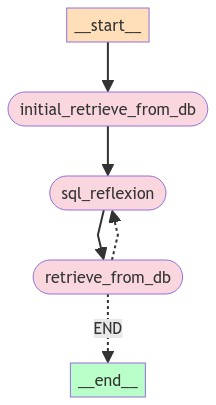

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
output_llama3 = graph.invoke({"messages": [
    ("human", "Get the total number of orders of each customer.")
]})

-----------------initial_retrieve_from_db-----------------
question :- Get the total number of orders of each customer.
retrieve_response :- content='' additional_kwargs={'tool_calls': [{'id': 'call_dx8n', 'function': {'arguments': '{"select_query":"SELECT c.name, COUNT(o.order_id) AS total_orders FROM customer c JOIN orders o ON c.customer_id = o.customer_id GROUP BY c.name","df_columns":["name","total_orders"],"df_name":"customer_orders","reflexion":{"good":"This query correctly joins the customer and orders tables to get the total number of orders for each customer.","improvements":"None","missing":"None"}}', 'name': 'AnswerQuestion'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 1903, 'total_tokens': 2039, 'completion_time': 0.427251407, 'prompt_time': 0.174083361, 'queue_time': None, 'total_time': 0.6013347680000001}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'tool_calls', 'logpro